In [83]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
import os
import torch
import hydra
from tqdm import tqdm

import numpy as np
import pickle
import pandas as pd
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
from draw_utils import get_antiSMASH_class, class_dict, class_dict_2, class_to_tensor, find_gbk, cal_metrics, extract_deepbgc_tsv

CURRENT_DIR=os.getcwd()
print(CURRENT_DIR)

/data5_large/home/kechenlu/natural_product/visualization


In [85]:
mpl.rcParams.update({
    'font.size': 8,
    'font.family': 'sans-serif',
    #'font.sans-serif': ['Arial'],  # Substitute with 'Helvetica' or system default
    'axes.linewidth': .75,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    #'xtick.direction': 'in',
    #'ytick.direction': 'in',
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'lines.linewidth': .75,
    'savefig.dpi': 600,
    'pdf.fonttype': 42,  # For editable text in Illustrator
    'ps.fonttype': 42,
})
plt.rcParams['figure.dpi'] = 600

CURRENT_DIR=os.getcwd()
print(CURRENT_DIR)
save_dir = os.path.join(CURRENT_DIR, "supporting_figs")

/data5_large/home/kechenlu/natural_product/visualization


In [4]:
with hydra.initialize(config_path =  os.path.join("..", "configs"), 
                        version_base="1.2"): 
    cfg = hydra.compose(config_name = "dataset" )

## antiSMASH performance calculation (Table 1)

### (1)Extract predicted classes by antismash

In [5]:
# Prepare Input File List for MiBIG
BGC_anno_path=os.path.join("..", "data", "antismash_annotation")
BGC_anno_extract=[] #a list of path of gbkfile to be extracted
for filename in os.listdir(BGC_anno_path):
    if filename.endswith(".gbk") and ".region" not in filename:
        full_path = os.path.join(BGC_anno_path, filename) #full path of one gbk file
        BGC_anno_extract.append(full_path)

antismash_predicted={}
all_predicted_classes=[]
for gbk_file in tqdm(BGC_anno_extract):
    BGC_number,predicted_classes=get_antiSMASH_class(gbk_file)
    if predicted_classes:
        all_predicted_classes.extend(predicted_classes)
    antismash_predicted[BGC_number]=predicted_classes
print(antismash_predicted)

100%|██████████| 2622/2622 [00:44<00:00, 59.44it/s] 

{'BGC0001328': ['NRPS', 'PKS'], 'BGC0001533': ['PKS'], 'BGC0002968': ['error'], 'BGC0000313': ['NRPS'], 'BGC0001066': ['NRPS', 'PKS'], 'BGC0000010': ['error'], 'BGC0002117': ['NRPS'], 'BGC0000946': ['other'], 'BGC0001179': ['PKS'], 'BGC0001828': ['PKS'], 'BGC0002451': ['NRPS', 'PKS'], 'BGC0002448': ['NRPS'], 'BGC0001411': ['other'], 'BGC0000171': ['PKS'], 'BGC0002072': ['PKS'], 'BGC0000439': ['NRPS'], 'BGC0001019': ['NRPS', 'PKS'], 'BGC0002533': ['NRPS', 'PKS'], 'BGC0001645': ['RiPP'], 'BGC0001215': ['NRPS', 'PKS'], 'BGC0000993': ['NRPS'], 'BGC0002528': ['NRPS'], 'BGC0002665': ['RiPP'], 'BGC0002125': ['NRPS'], 'BGC0001458': ['other'], 'BGC0002214': ['PKS'], 'BGC0000222': ['PKS'], 'BGC0002545': ['PKS'], 'BGC0002015': ['RiPP'], 'BGC0001329': ['NRPS', 'PKS'], 'BGC0002346': ['RiPP'], 'BGC0002508': ['error'], 'BGC0000387': ['error'], 'BGC0000486': ['RiPP'], 'BGC0001018': ['NRPS'], 'BGC0001549': ['RiPP'], 'BGC0000660': ['terpene'], 'BGC0001457': ['NRPS', 'PKS'], 'BGC0002535': ['NRPS'], 'BGC0

In [6]:
# Map extracted class to standard form
convert_dict = {'other':"Other", 'RiPP':"RiPP", 'PKS':"Polyketide", 'saccharide':"Saccharide", 'error':"error", 'terpene':"Terpene", 'NRPS':"NRP"}
antismash_predicted = {key: [item.lower() for item in value] for key, value in antismash_predicted.items()}
convert_dict={key.lower():value for key,value in convert_dict.items()}
for key, value in antismash_predicted.items():
    for item in value:
        if item not in convert_dict.keys():
            print(item,key)
antismash_mapped={key:list(set([convert_dict[item] for item in value])) for key,value in antismash_predicted.items()}
print(antismash_mapped)

{'BGC0001328': ['NRP', 'Polyketide'], 'BGC0001533': ['Polyketide'], 'BGC0002968': ['error'], 'BGC0000313': ['NRP'], 'BGC0001066': ['NRP', 'Polyketide'], 'BGC0000010': ['error'], 'BGC0002117': ['NRP'], 'BGC0000946': ['Other'], 'BGC0001179': ['Polyketide'], 'BGC0001828': ['Polyketide'], 'BGC0002451': ['NRP', 'Polyketide'], 'BGC0002448': ['NRP'], 'BGC0001411': ['Other'], 'BGC0000171': ['Polyketide'], 'BGC0002072': ['Polyketide'], 'BGC0000439': ['NRP'], 'BGC0001019': ['NRP', 'Polyketide'], 'BGC0002533': ['NRP', 'Polyketide'], 'BGC0001645': ['RiPP'], 'BGC0001215': ['NRP', 'Polyketide'], 'BGC0000993': ['NRP'], 'BGC0002528': ['NRP'], 'BGC0002665': ['RiPP'], 'BGC0002125': ['NRP'], 'BGC0001458': ['Other'], 'BGC0002214': ['Polyketide'], 'BGC0000222': ['Polyketide'], 'BGC0002545': ['Polyketide'], 'BGC0002015': ['RiPP'], 'BGC0001329': ['NRP', 'Polyketide'], 'BGC0002346': ['RiPP'], 'BGC0002508': ['error'], 'BGC0000387': ['error'], 'BGC0000486': ['RiPP'], 'BGC0001018': ['NRP'], 'BGC0001549': ['RiPP'

In [7]:
# Save antiSMASH prediction data on BGC-MAC test data to csv file
series = pd.Series(antismash_mapped)
df = pd.DataFrame({
    'BGC_number': series.index,
    'Prediction_Result': series.values
})
df["Prediction_Result"] = df["Prediction_Result"].apply(lambda x:"-".join(x))
df.to_csv("../data/antismash_annotation/antiSMASH_prediction.csv", index = False)
df

,BGC_number,Prediction_Result
0,BGC0001328,NRP-Polyketide
1,BGC0001533,Polyketide
2,BGC0002968,error
3,BGC0000313,NRP
4,BGC0001066,NRP-Polyketide
...,...,...
2617,BGC0001757,error
2618,BGC0000009,Polyketide
2619,BGC0000405,NRP
2620,BGC0000290,NRP-Polyketide


### (2) Calculate the TP,FN,FP of antismash prediction

In [8]:
test_data = pd.read_pickle("../ckpt/BGC_MAC/test_MAC_metadata_43.pkl")
true_class = test_data.set_index("BGC_number")["biosyn_class"].to_dict()

In [9]:
def calculate_antismash_performance(true_class, antismash_mapped):
    """
    antismash_mapped: a dictation with all antismash predicted results in MiBIG database 4.0 -> prediction results
    """
    if not torch.is_tensor(list(true_class.values())[0]):
        true_class = {key:class_to_tensor(value,class_dict_2) for key,value in true_class.items()} #vectorize the true classes
    # change the order to BGC order in test data
    # If no antiSMASH output, default is error
    antismash_selected = {key: antismash_mapped.get(key, ["error"]) for key in true_class.keys()} 
    antismash_vectorized={key:class_to_tensor(value,class_dict_2) for key,value in antismash_selected.items()} #vectorize the predicted classes

    true = torch.vstack(list(true_class.values())).numpy()
    pred = torch.vstack(list(antismash_vectorized.values())).numpy()
    class_num = np.sum(true , axis=0)
    metrics = cal_metrics(pred, true)
    return metrics, class_num, pred

metrics, class_num, pred = calculate_antismash_performance(true_class, antismash_mapped)

print(metrics)

for i in range(len(class_dict)):
    print(list(class_dict.keys())[i],class_num[i])
    print(f"  f1: {metrics['f1'][i]:.4f}")
    print(f"  Precision: {metrics['precision'][i]:.4f}")
    print(f"  Recall: {metrics['recall'][i]:.4f}")

# torch.save(pred, os.path.join(CURRENT_DIR, "..", "ckpt", "BGC_MAC", "antismash_pred_43.pth"))

{'precision': [np.float64(0.8641975308641975), np.float64(0.5121951219512195), np.float64(0.8796296296296297), np.float64(0.9024390243902439), np.float64(0.3333333333333333), np.float64(0.8666666666666667)], 'recall': [np.float64(0.8974358974358975), np.float64(0.40384615384615385), np.float64(0.9595959595959596), np.float64(0.9487179487179487), np.float64(0.04), np.float64(0.7647058823529411)], 'f1': [np.float64(0.880503144654088), np.float64(0.45161290322580644), np.float64(0.9178743961352657), np.float64(0.9249999999999999), np.float64(0.07142857142857142), np.float64(0.8125)], 'AUC': [np.float64(0.9189882189882189), np.float64(0.6545297119941669), np.float64(0.9401638334565164), np.float64(0.9654304029304028), np.float64(0.5157983193277311), np.float64(0.878287900526064)]}
NRPS 78
  f1: 0.8805
  Precision: 0.8642
  Recall: 0.8974
other 52
  f1: 0.4516
  Precision: 0.5122
  Recall: 0.4038
PKS 99
  f1: 0.9179
  Precision: 0.8796
  Recall: 0.9596
ribosomal 39
  f1: 0.9250
  Precision:

### (3) Fig S3C Compare the performance between BGC-MAC and antiSMASH in fungi BGC

In [10]:
fungi_path = "../data/fungi_bgc"
fungi_file_path = []
for filename in os.listdir(fungi_path):
    if filename.endswith(".gbk"):
        full_path = os.path.join(fungi_path, filename) #full path of one gbk file
        fungi_file_path.append(full_path)

antismash_predicted={}
all_predicted_classes=[]
for gbk_file in tqdm(fungi_file_path):
    BGC_number, predicted_classes=get_antiSMASH_class(gbk_file)
    if predicted_classes:
        all_predicted_classes.extend(predicted_classes)
    antismash_predicted[BGC_number]=predicted_classes

convert_dict = {'other':"Other", 'RiPP':"RiPP", 'PKS':"Polyketide", 'saccharide':"Saccharide", 'error':"error", 'terpene':"Terpene", 'NRPS':"NRP"}
antismash_predicted = {key: [item.lower() for item in value] for key, value in antismash_predicted.items()}
convert_dict={key.lower():value for key,value in convert_dict.items()}
for key, value in antismash_predicted.items():
    for item in value:
        if item not in convert_dict.keys():
            print(item,key)
antismash_mapped={key:list(set([convert_dict[item] for item in value])) for key,value in antismash_predicted.items()}
print(antismash_mapped)

100%|██████████| 7162/7162 [03:53<00:00, 30.72it/s]

{'NW_001939246.1.region006': ['Polyketide'], 'NW_024467309.1.region001': ['NRP'], 'NW_020290898.1.region002': ['RiPP'], 'NW_006912941.1.region001': ['RiPP'], 'NW_026250019.1.region005': ['Polyketide'], 'NW_024469080.1.region001': ['NRP'], 'NW_024467212.1.region001': ['Terpene'], 'NW_025953261.1.region002': ['RiPP'], 'NW_025953045.1.region002': ['Polyketide'], 'NW_020291814.1.region004': ['Other', 'RiPP'], 'NW_024467538.1.region003': ['Polyketide'], 'NC_072350.1.region007': ['RiPP'], 'NW_024467200.1.region001': ['Other'], 'NW_017387734.1.region001': ['NRP'], 'NW_011942193.1.region001': ['Terpene'], 'NW_024067573.1.region001': ['Polyketide'], 'NW_025953821.1.region001': ['RiPP', 'Polyketide'], 'NW_015971579.1.region002': ['Polyketide'], 'NW_011942179.1.region001': ['NRP'], 'NW_014013689.1.region001': ['Terpene'], 'NW_017263588.1.region001': ['RiPP'], 'NW_006917093.1.region007': ['NRP'], 'NW_019671930.1.region001': ['Terpene'], 'NW_017264916.1.region001': ['NRP'], 'NC_058393.1.region003':

In [11]:
antismash_vectorized={key:class_to_tensor(value,class_dict_2) for key,value in antismash_mapped.items()} #vectorize the predicted classes
antismash_vectorized

{'NW_001939246.1.region006': tensor([0, 0, 1, 0, 0, 0]),
 'NW_024467309.1.region001': tensor([1, 0, 0, 0, 0, 0]),
 'NW_020290898.1.region002': tensor([0, 0, 0, 1, 0, 0]),
 'NW_006912941.1.region001': tensor([0, 0, 0, 1, 0, 0]),
 'NW_026250019.1.region005': tensor([0, 0, 1, 0, 0, 0]),
 'NW_024469080.1.region001': tensor([1, 0, 0, 0, 0, 0]),
 'NW_024467212.1.region001': tensor([0, 0, 0, 0, 0, 1]),
 'NW_025953261.1.region002': tensor([0, 0, 0, 1, 0, 0]),
 'NW_025953045.1.region002': tensor([0, 0, 1, 0, 0, 0]),
 'NW_020291814.1.region004': tensor([0, 1, 0, 1, 0, 0]),
 'NW_024467538.1.region003': tensor([0, 0, 1, 0, 0, 0]),
 'NC_072350.1.region007': tensor([0, 0, 0, 1, 0, 0]),
 'NW_024467200.1.region001': tensor([0, 1, 0, 0, 0, 0]),
 'NW_017387734.1.region001': tensor([1, 0, 0, 0, 0, 0]),
 'NW_011942193.1.region001': tensor([0, 0, 0, 0, 0, 1]),
 'NW_024067573.1.region001': tensor([0, 0, 1, 0, 0, 0]),
 'NW_025953821.1.region001': tensor([0, 0, 1, 1, 0, 0]),
 'NW_015971579.1.region002': tenso

In [12]:
def compress_to_tensor(df):
    paths = df.iloc[:, 0]
    
    tensor_data = df.iloc[:, 1:7].values  
    
    tensors = torch.tensor(tensor_data, dtype=torch.float32)
    
    result_df = pd.DataFrame({
        'BGC_number': paths,
        'MAC_prediction': list(tensors) 
    })
    
    return result_df

In [14]:
MAC_result = pd.read_csv("../output/MAC_antiSMASH_fungi_bgc.csv")
MAC_result_tensor = compress_to_tensor(MAC_result)
MAC_result_tensor["BGC_number"] = MAC_result_tensor["BGC_number"].apply(lambda x:os.path.splitext(os.path.basename(x))[0])
MAC_result_tensor["antiSMASH_prediction"] = MAC_result_tensor["BGC_number"].map(antismash_vectorized)
MAC_result_tensor

,BGC_number,MAC_prediction,antiSMASH_prediction
0,NW_001939246.1.region006,"[tensor(0.0100), tensor(0.0200), tensor(0.9900...","[tensor(0), tensor(0), tensor(1), tensor(0), t..."
1,NW_024467309.1.region001,"[tensor(0.1000), tensor(0.8100), tensor(0.0100...","[tensor(1), tensor(0), tensor(0), tensor(0), t..."
2,NW_020290898.1.region002,"[tensor(0.0200), tensor(0.8400), tensor(0.0700...","[tensor(0), tensor(0), tensor(0), tensor(1), t..."
3,NW_006912941.1.region001,"[tensor(0.0200), tensor(0.3200), tensor(0.0100...","[tensor(0), tensor(0), tensor(0), tensor(1), t..."
4,NW_026250019.1.region005,"[tensor(0.0100), tensor(0.0100), tensor(0.9900...","[tensor(0), tensor(0), tensor(1), tensor(0), t..."
...,...,...,...
7157,NW_013566946.1.region001,"[tensor(0.9800), tensor(0.2700), tensor(0.), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t..."
7158,NW_024469005.1.region001,"[tensor(0.1000), tensor(0.5200), tensor(0.0100...","[tensor(1), tensor(0), tensor(0), tensor(0), t..."
7159,NC_049566.1.region002,"[tensor(0.0100), tensor(0.0100), tensor(0.9900...","[tensor(0), tensor(0), tensor(1), tensor(0), t..."
7160,NW_024467299.1.region001,"[tensor(0.1500), tensor(0.5700), tensor(0.0100...","[tensor(1), tensor(0), tensor(0), tensor(0), t..."


In [15]:
MAC_prediction = np.array(torch.stack(MAC_result_tensor["MAC_prediction"].to_list(), dim = 0))
antiSMASH_prediction = np.array(torch.stack(MAC_result_tensor["antiSMASH_prediction"].to_list(), dim = 0))


/tmp/ipykernel_3396736/2759749744.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  MAC_prediction = np.array(torch.stack(MAC_result_tensor["MAC_prediction"].to_list(), dim = 0))
/tmp/ipykernel_3396736/2759749744.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  antiSMASH_prediction = np.array(torch.stack(MAC_result_tensor["antiSMASH_prediction"].to_list(), dim = 0))


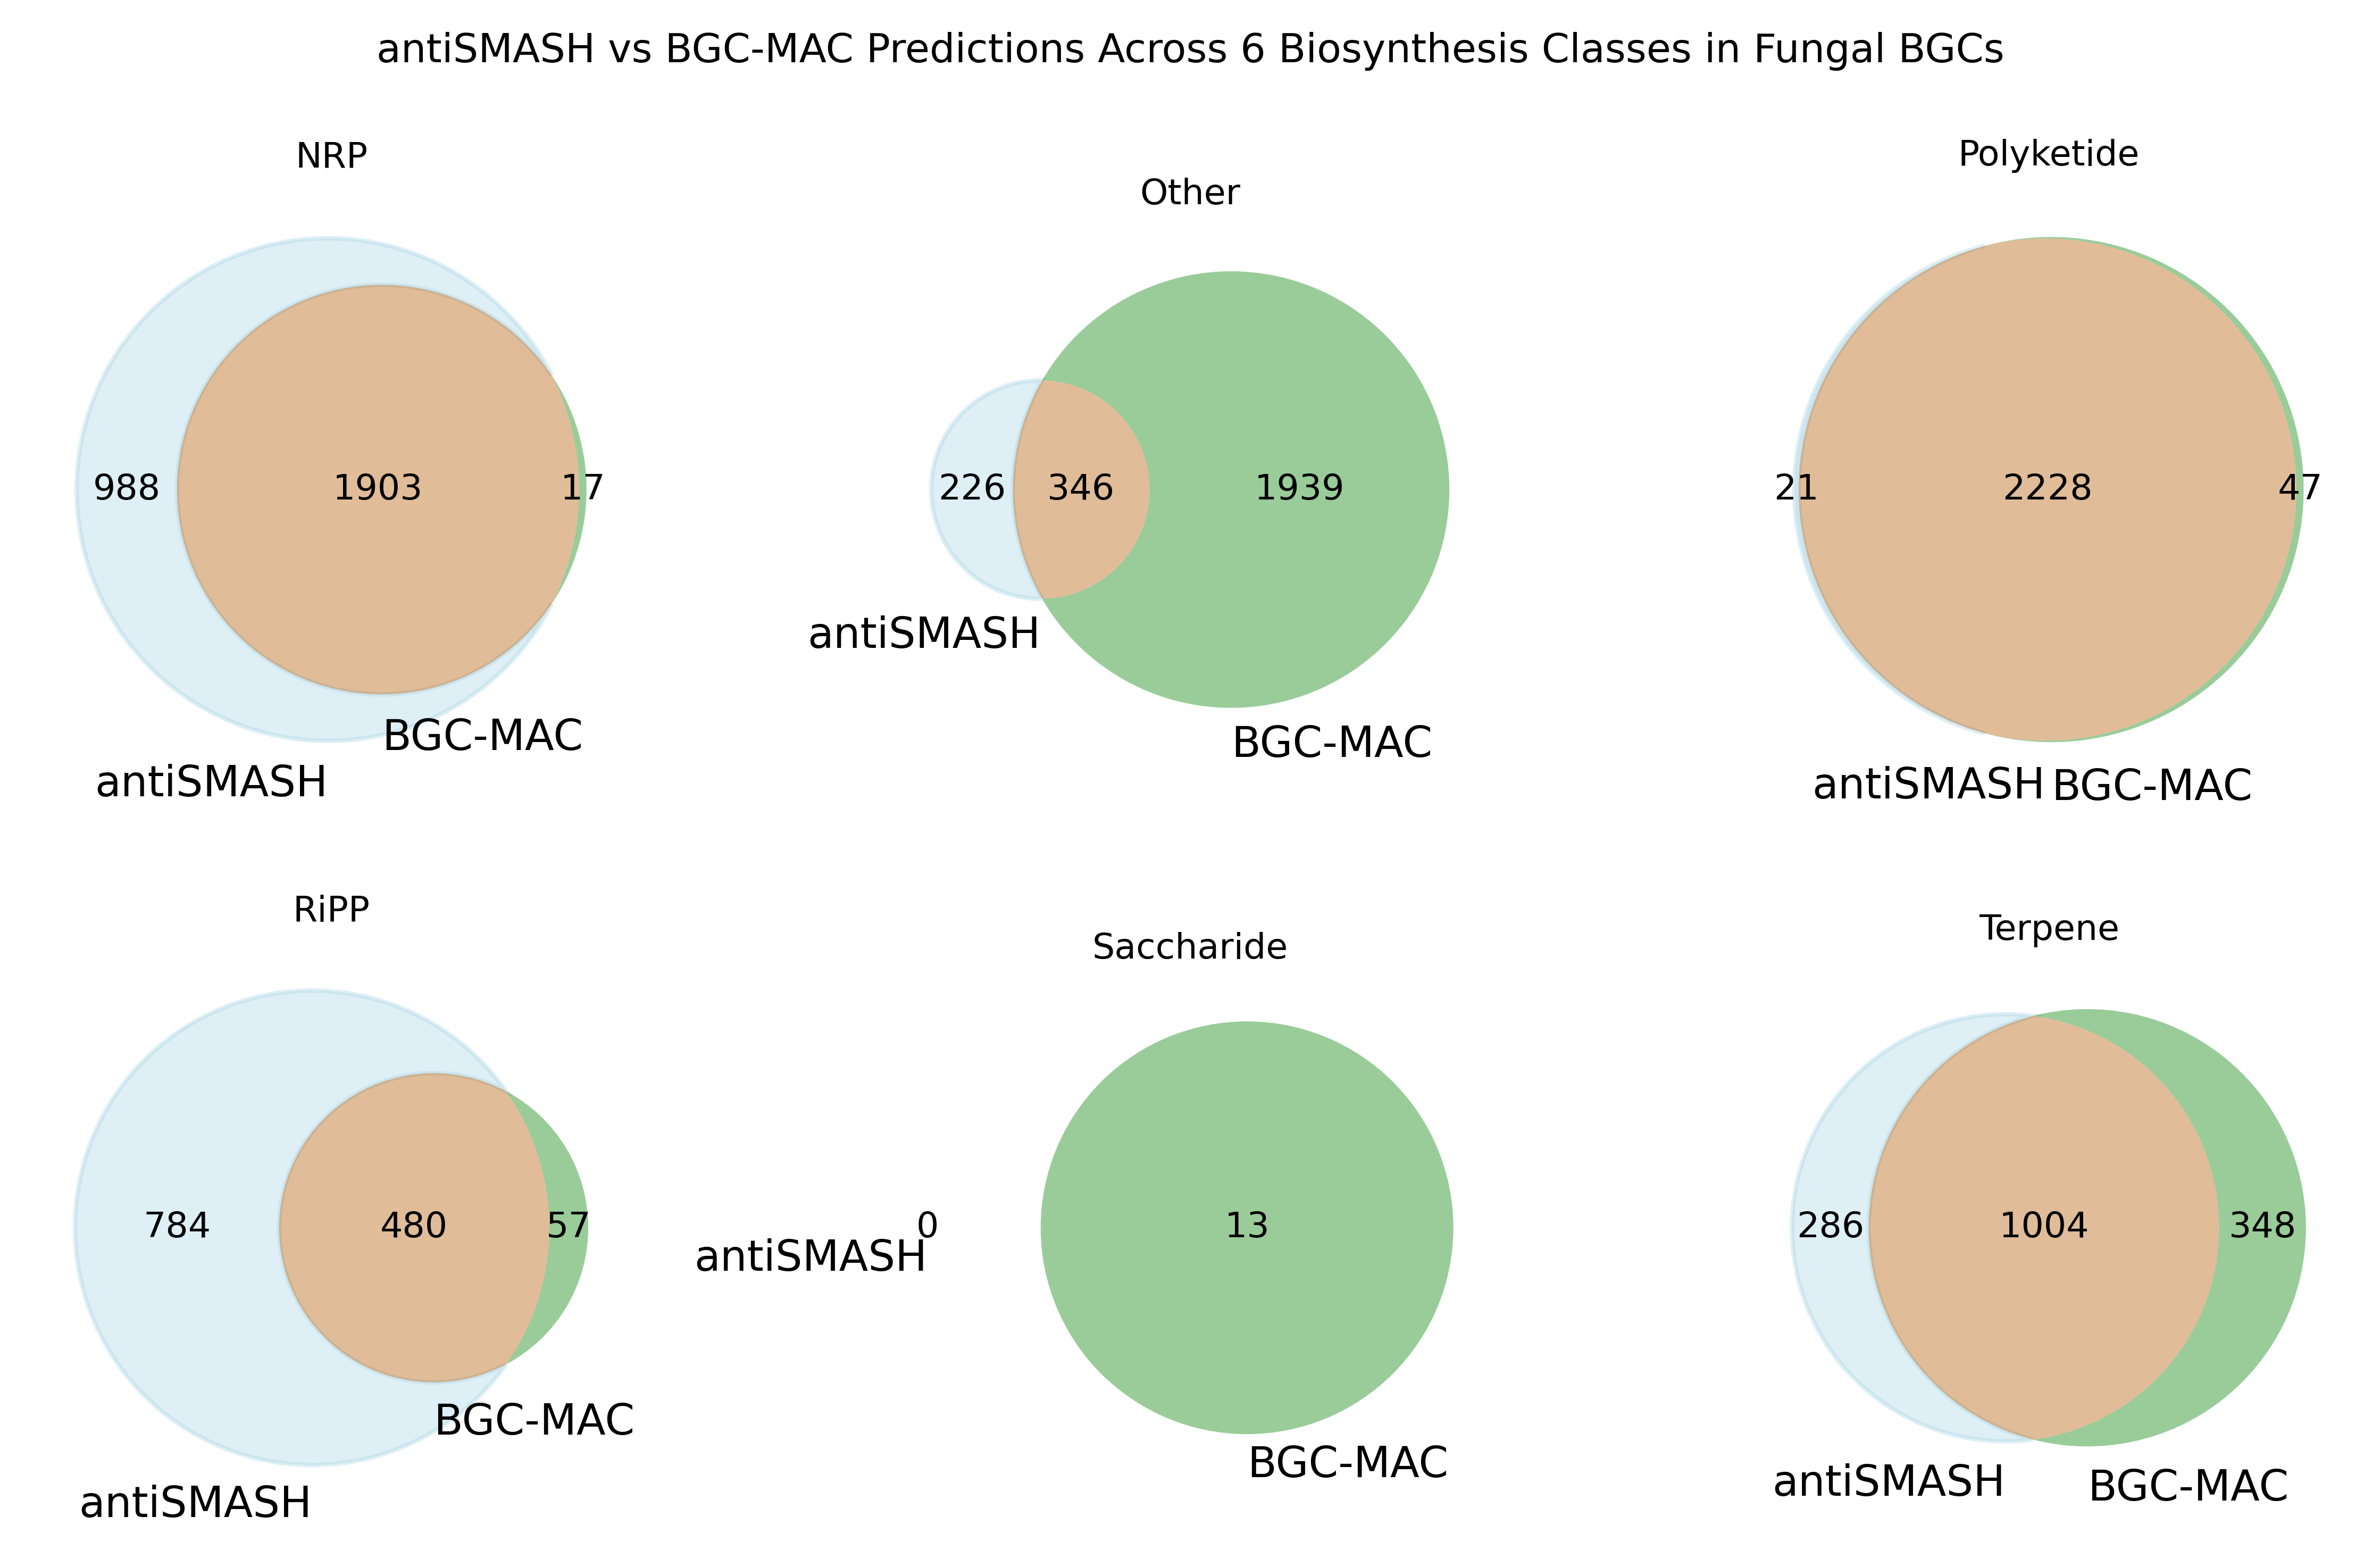

In [16]:
from matplotlib_venn import venn2

venn_data = []
print_results = True 

for i in range(6):
    a, b = antiSMASH_prediction[:, i], np.round(MAC_prediction)[:, i]

    a_only = np.sum((a == 1) & (b == 0))
    b_only = np.sum((a == 0) & (b == 1))
    ab_both = np.sum((a == 1) & (b == 1))

    same_total = np.sum(a == b)
    both_zero = np.sum((a == 0) & (b == 0))
    different = np.sum(a != b)


    venn_data.append((a_only, b_only, ab_both))

fig, axes = plt.subplots(2, 3, figsize=(7.5, 5))  
fig.suptitle('antiSMASH vs BGC-MAC Predictions Across 6 Biosynthesis Classes in Fungal BGCs', fontsize=9)

for i in range(6):
    row = i // 3
    col = i % 3
    ax = axes[row, col]

    # subsets = (A_only, B_only, AB_both)
    venn = venn2(subsets=(venn_data[i][0], venn_data[i][1], venn_data[i][2]),
                 set_labels=('antiSMASH', 'BGC-MAC'),
                 ax=ax)

    category_name = list(class_dict_2)[i]  
    ax.set_title(category_name, fontsize=8)

    if venn:
        venn.get_patch_by_id('10').set_color('lightblue')  # A only
        #venn.get_patch_by_id('01').set_color('lightgreen')  # B only
        #venn.get_patch_by_id('11').set_color('lightcoral')  # Both

plt.tight_layout()  
#plt.savefig(os.path.join(save_dir, "Fungal_BGC_performance.pdf"), format='pdf')
plt.show()

## Analysis DeepBGC (Table 1)

https://github.com/Merck/deepbgc

### (1) Retrain DeepBGC preparation

In [19]:
test_data = pd.read_pickle("../ckpt/BGC_MAC/test_MAC_metadata_43.pkl")
mibig_3 = pd.read_csv("../data/deepBGC/train/training_set/MIBiG_3.0_classes.csv")
mibig_3_id = mibig_3["sequence_id"].to_list()
MAC_metadata = pd.read_pickle("../data/BGC_4.0/MAC_metadata.pkl")
mibig_4_id = MAC_metadata["BGC_number"].to_list()
to_be_annotation = set(mibig_4_id) - set(mibig_3_id)
MAC_test_BGC = test_data["BGC_number"].to_list()

print(to_be_annotation)

{'BGC0002926', 'BGC0002864', 'BGC0002981', 'BGC0002931', 'BGC0002940', 'BGC0002994', 'BGC0003029', 'BGC0002928', 'BGC0003088', 'BGC0003115', 'BGC0003130', 'BGC0002880', 'BGC0003162', 'BGC0002846', 'BGC0002959', 'BGC0002958', 'BGC0002884', 'BGC0003163', 'BGC0003155', 'BGC0003041', 'BGC0003089', 'BGC0003085', 'BGC0002852', 'BGC0003137', 'BGC0003051', 'BGC0003073', 'BGC0002873', 'BGC0002805', 'BGC0003042', 'BGC0003109', 'BGC0002862', 'BGC0002986', 'BGC0002865', 'BGC0002877', 'BGC0002851', 'BGC0002813', 'BGC0002825', 'BGC0002779', 'BGC0003140', 'BGC0002990', 'BGC0002918', 'BGC0003043', 'BGC0003028', 'BGC0002992', 'BGC0002983', 'BGC0002989', 'BGC0002911', 'BGC0003011', 'BGC0002871', 'BGC0002775', 'BGC0002897', 'BGC0002954', 'BGC0003104', 'BGC0003107', 'BGC0002950', 'BGC0003119', 'BGC0003134', 'BGC0003054', 'BGC0002978', 'BGC0003065', 'BGC0003044', 'BGC0003165', 'BGC0002909', 'BGC0003145', 'BGC0002878', 'BGC0003025', 'BGC0003099', 'BGC0002886', 'BGC0002900', 'BGC0003097', 'BGC0003015', 'BGC0

In [ ]:
# Create DeepBGC input
import shutil

for BGC_num in tqdm(to_be_annotation, desc = "copying files"):
    source_file = os.path.join("../data/mibig_gbk_4.0", f"{BGC_num}.gbk")
    destination_file = os.path.join("../data/deepBGC/train/to_be_annotation", f"{BGC_num}.gbk")
    shutil.copy2(source_file, destination_file)

# Then run deepbgc_prepare.py to get pfam lists (tsv file)

copying files: 100%|██████████| 220/220 [00:03<00:00, 67.84it/s] 


In [20]:
# find bgcs in training set
# Create new DataFrame with one-hot encoding for biosyn_class

train_validation_id = set(mibig_4_id) - set(MAC_test_BGC) # Fold1-9

test_id = test_data["BGC_number"].to_list()
train_validation_id = set(mibig_4_id) - set(test_id)
class_mapping = {"NRPS":"NRP", "other": "Other", "PKS": "Polyketide","Ribosomal": "RiPP" ,"saccharide": "Saccharide" ,"terpene":"Terpene"}

def create_one_hot_bgc_df(df, class_mapping):
    result_df = pd.DataFrame()
    result_df['sequence_id'] = df['BGC_number']
    
    categories = ['NRP', 'Other', 'Polyketide', 'RiPP', 'Saccharide', 'Terpene']
    
    for category in categories:
        result_df[category] = 0
    
    for idx, row in df.iterrows():
        bgc_id = row['BGC_number']
        classes = row['biosyn_class'] 
        
        for cls in classes:
            cls_normalized = cls.strip().lower()
            
            mapped_category = None
            for key, value in class_mapping.items():
                if cls_normalized == key.lower():
                    mapped_category = value
                    break
            
            if mapped_category and mapped_category in categories:
                result_df.loc[result_df['sequence_id'] == bgc_id, mapped_category] = 1
    
    return result_df

new_df = create_one_hot_bgc_df(MAC_metadata, class_mapping)
print(new_df)


     sequence_id  NRP  Other  Polyketide  RiPP  Saccharide  Terpene
0     BGC0000001    0      0           1     0           0        0
1     BGC0000002    0      0           1     0           0        0
2     BGC0000003    0      0           1     0           0        0
3     BGC0000004    0      0           1     0           0        0
4     BGC0000006    0      0           1     0           0        0
...          ...  ...    ...         ...   ...         ...      ...
2630  BGC0003164    1      0           0     0           1        0
2631  BGC0003165    1      0           0     0           1        0
2632  BGC0003168    1      0           0     0           1        0
2633  BGC0003169    1      0           0     0           0        0
2634  BGC0003170    1      0           0     0           0        0

[2635 rows x 7 columns]


In [ ]:
import glob
from pathlib import Path

# Merge to be annon and mibig3.0 tsv (from deepbgc github)
def merge_tsv_files(folder_path, pattern="*.tsv", index_col=None):
    file_pattern = Path(folder_path) / pattern
    tsv_files = glob.glob(str(file_pattern))
    
    if not tsv_files:
        print(f"Didn't find any files matching: {pattern}")
        return pd.DataFrame()
    
    print(f"Find {len(tsv_files)} tsv files")
    
    dfs = []
    for file_path in sorted(tsv_files):  
        try:
            df = pd.read_csv(file_path, sep='\t', index_col=index_col)
            dfs.append(df)
            print(f"Read: {Path(file_path).name} ({len(df)} row)")
        except Exception as e:
            print(f"Fail to read {file_path}: {e}")
    
    if not dfs:
        return pd.DataFrame()
    
    merged_df = pd.concat(dfs, ignore_index=True)

    
    print(f"\nDone. {len(merged_df)} row in total")
    return merged_df

mibig_pfam = merge_tsv_files("../data/deepBGC/train/training_set", pattern="*.tsv", index_col=None)

In [ ]:
# create final training file
mibig_pfam_train = mibig_pfam[mibig_pfam["sequence_id"].isin(train_validation_id)]
mibig_class_train = new_df[new_df["sequence_id"].isin(train_validation_id)]
# delete BGC without pfam annotation
mibig_pfam_train = mibig_pfam[mibig_pfam["sequence_id"].isin(mibig_class_train["sequence_id"].to_list())]


In [ ]:
mibig_pfam_train.to_csv("../data/deepBGC/train/MIBiG_4.0_pfam_train.tsv", sep='\t', index=False)
mibig_class_train.to_csv("../data/deepBGC/train/MIBiG_4.0_class_train.csv", index=False)

### (2) DeepBGC result analysis

In [21]:
# read results of deepbgc
deepbgc_path = "../data/deepBGC/strict_classify"
BGC_number = []
deepbgc_result = []
prediction_score = []
for folder_name in tqdm(os.listdir(deepbgc_path), desc = "processing deepbgc results"):
    if folder_name.startswith("BGC") and os.path.isdir(os.path.join(deepbgc_path, folder_name)):
        bgc_folder_path = os.path.join(deepbgc_path, folder_name)

        json_file_path = os.path.join(bgc_folder_path, f"{folder_name}.antismash.json")
        tsv_file_path = os.path.join(bgc_folder_path, f"{folder_name}.bgc.tsv")
        if os.path.isfile(json_file_path):
            try:
                with open(json_file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    try:
                        deepbgc_result.append(data["records"][0]["subregions"][0]["details"]["Mibig4DeepBGCClassifier"])
                        prediction_score.append(extract_deepbgc_tsv(tsv_file_path))
                    except Exception as e:
                        print("no predictions")
                        deepbgc_result.append("error")
                        prediction_score.append(torch.tensor([0.,0.,0.,0.,0.,0.]))
                    BGC_number.append(folder_name)
                                        
                    
            except json.JSONDecodeError:
                print(f"Error: {folder_name}/antismash.json invalid format")
            except Exception as e:
                print(f"Fail to read {folder_name}/antismash.json : {str(e)}")
        else:
            print(f"Warning: {folder_name} doesn't contain antismash.json")

df = pd.DataFrame({
    'BGC_number': BGC_number,
    'biosyn_class': deepbgc_result,
    'prediction_score': prediction_score
})

processing deepbgc results:   4%|▍         | 10/265 [00:00<00:06, 40.83it/s]

no predictions


processing deepbgc results:   9%|▉         | 24/265 [00:00<00:06, 35.52it/s]

no predictions


processing deepbgc results:  34%|███▎      | 89/265 [00:02<00:04, 38.07it/s]

no predictions


processing deepbgc results:  43%|████▎     | 114/265 [00:03<00:04, 37.01it/s]

no predictions


processing deepbgc results:  63%|██████▎   | 168/265 [00:04<00:02, 47.16it/s]

no predictions


processing deepbgc results:  74%|███████▎  | 195/265 [00:04<00:01, 48.81it/s]

no predictions


processing deepbgc results:  82%|████████▏ | 216/265 [00:05<00:01, 42.40it/s]

no predictions
no predictions


processing deepbgc results:  89%|████████▉ | 236/265 [00:05<00:00, 40.23it/s]

no predictions
no predictions


processing deepbgc results: 100%|██████████| 265/265 [00:06<00:00, 40.38it/s]


In [22]:
df['biosyn_class'] = df['biosyn_class'].replace('no confident class', 'error')
df['biosyn_class'] = df['biosyn_class'].replace('Alkaloid', 'Other')
df["biosyn_class"] = df["biosyn_class"].apply(lambda x: x.split("-"))
df

,BGC_number,biosyn_class,prediction_score
0,BGC0000777,[Saccharide],"[tensor(0.0100, dtype=torch.float64), tensor(0..."
1,BGC0001879,[error],"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,BGC0000212,[Polyketide],"[tensor(0.0300, dtype=torch.float64), tensor(0..."
3,BGC0001374,[error],"[tensor(0.0600, dtype=torch.float64), tensor(0..."
4,BGC0000037,[Polyketide],"[tensor(0.0700, dtype=torch.float64), tensor(0..."
...,...,...,...
258,BGC0000890,[Other],"[tensor(0.1200, dtype=torch.float64), tensor(0..."
259,BGC0002381,[Polyketide],"[tensor(0.3500, dtype=torch.float64), tensor(0..."
260,BGC0000562,[RiPP],"[tensor(0.0900, dtype=torch.float64), tensor(0..."
261,BGC0000707,[error],"[tensor(0.1100, dtype=torch.float64), tensor(0..."


In [23]:
# ONLY UNSED FOR SAVING DEEPBGC PREDICTION RESULTS, NOT FOR ANALYSIS
col_names = ['NRP', 'Other', 'Polyketide', 'RiPP', 'Saccharide', 'Terpene']

tensor_values = []
for tensor in df['prediction_score']:
    if isinstance(tensor, torch.Tensor):
        if tensor.is_cuda:
            tensor = tensor.cpu()
        tensor_values.append(tensor.detach().numpy())
    else:
        tensor_values.append(np.array(tensor))

expanded_df = pd.DataFrame(
    np.stack(tensor_values, axis=0), 
    columns=col_names, 
    index=df.index
)

df_for_save = pd.concat([df.drop('prediction_score', axis=1), expanded_df], axis=1)
df_for_save["biosyn_class"] = df_for_save["biosyn_class"].replace("RiPP", "RiPPs")

#df_for_save.to_csv("../data/deepBGC/deepbgc_predictions.csv", index = False)

In [24]:
true_class = test_data.set_index("BGC_number")["biosyn_class"].to_dict()
deepbgc_score = df.set_index("BGC_number")["prediction_score"].to_dict()
deepbgc_score_selected = {key: deepbgc_score.get(key, torch.tensor([0., 0., 0., 0., 0., 0.])) for key in true_class.keys()}
true = torch.vstack(list(true_class.values())).numpy()
pred = torch.vstack(list(deepbgc_score_selected.values())).numpy()
class_num = np.sum(true , axis=0)

metrics = cal_metrics(pred, true)

for i in range(len(class_dict)):
    print(list(class_dict.keys())[i],class_num[i])
    print(f"  f1: {metrics['f1'][i]:.4f}")
    print(f"  Precision: {metrics['precision'][i]:.4f}")
    print(f"  Recall: {metrics['recall'][i]:.4f}")
    print(f"  AUC: {metrics['AUC'][i]:.4f}")


NRPS 78
  f1: 0.8627
  Precision: 0.8800
  Recall: 0.8462
  AUC: 0.9400
other 52
  f1: 0.4058
  Precision: 0.8235
  Recall: 0.2692
  AUC: 0.7829
PKS 99
  f1: 0.9163
  Precision: 0.8942
  Recall: 0.9394
  AUC: 0.9501
ribosomal 39
  f1: 0.9211
  Precision: 0.9459
  Recall: 0.8974
  AUC: 0.9776
saccharide 25
  f1: 0.7619
  Precision: 0.9412
  Recall: 0.6400
  AUC: 0.9374
terpene 17
  f1: 0.7097
  Precision: 0.7857
  Recall: 0.6471
  AUC: 0.8973


## BGC border analysis (Table S7)

### (1) Prepare analysis files

In [86]:
border_data = pd.read_csv("../data/border/knownclusterblast_MACtest_hits.csv", sep = "\t")
MAC_test_data = pd.read_pickle("../ckpt/BGC_MAC/test_MAC_metadata_43.pkl")
test_BGC = MAC_test_data["BGC_number"].to_list()
border_data_100 = border_data[border_data["Similarity in %"] == 100]
border_data_100 = border_data_100[border_data_100["MIBiG BGC-ID"].isin(test_BGC)]
border_data_100

,#Genus,Species,Strain,NCBI accession,From,To,BGC type,On contig edge,Most similar known cluster,Similarity in %,MIBiG BGC-ID,Results URL
34,Bacillus,cereus,HuA4-10,NZ_JH792148.1,1835686,1859596,lassopeptide,False,paeninodin,100,BGC0001356,https://antismash-db.secondarymetabolites.org/...
67,Streptomyces,Unknown,PVA 94-07,NZ_CM002273.1,2912897,2935471,lanthipeptide-class-iii,False,AmfS,100,BGC0000496,https://antismash-db.secondarymetabolites.org/...
73,Pseudomonas,aeruginosa,PS42,NZ_KI914437.1,1882749,1941249,t1pks t3pks hybrid,False,pyoluteorin,100,BGC0000128,https://antismash-db.secondarymetabolites.org/...
101,Paenibacillus,Unknown,FSL H7-0357,NZ_CP009241.1,886021,909913,lassopeptide,False,paeninodin,100,BGC0001356,https://antismash-db.secondarymetabolites.org/...
103,Paenibacillus,Unknown,FSL P4-0081,NZ_CP009280.1,1032462,1056352,lassopeptide,False,paeninodin,100,BGC0001356,https://antismash-db.secondarymetabolites.org/...
...,...,...,...,...,...,...,...,...,...,...,...,...
41462,Acinetobacter,Unknown,JXA13,NZ_CP054137.1,1142328,1195531,nrp-metallophore,False,acinetobactin,100,BGC0000294,https://antismash-db.secondarymetabolites.org/...
41482,Streptomyces,Unknown,OspMP-M45,NZ_LACQ01000001.1,139768,191091,lanthipeptide-class-ii lanthipeptide-class-iii...,False,albusnodin,100,BGC0002006,https://antismash-db.secondarymetabolites.org/...
41483,Streptomyces,Unknown,OspMP-M45,NZ_LACQ01000003.1,88122,139888,terpene thiopeptide lap hybrid,False,isorenieratene,100,BGC0000664,https://antismash-db.secondarymetabolites.org/...
41491,Bacillus,Unknown,SN1,NZ_PHIE01000001.1,499223,630688,transat-pks nrps betalactone hybrid,False,fengycin,100,BGC0001095,https://antismash-db.secondarymetabolites.org/...


In [87]:
base_dir = "../data/border"
row = border_data_100.iloc[0]
gbk_file = find_gbk(row, base_dir)

In [88]:
# Length analysis
# Mibig BGC size
MAC_test_data["Length"] = MAC_test_data["enzyme_list"].apply(len)
print(np.mean(MAC_test_data["Length"])) #MEAN:27.13

27.136882129277566


In [89]:
# antiSMASH BGC size
from data_preparation.BGC import Bgc

def get_length(gbk_file):
    BGC = Bgc(gbk_file, database = "new", product = None)
    return len(BGC.enzyme_list)

border_data_100_sampled = border_data_100.groupby('MIBiG BGC-ID').sample(n=1, random_state=42).reset_index(drop=True)
border_data_100_sampled["gbk_file"] = border_data_100_sampled.apply(lambda row: find_gbk(row, base_dir), axis=1)

border_data_100_sampled["length"] = border_data_100_sampled["gbk_file"].apply(get_length)
print(np.mean(border_data_100_sampled["length"])) #MEAN:34.22


34.21978021978022


In [ ]:
# copy files for BGC-MAC classification
import shutil
for gbk_file in border_data_100_sampled["gbk_file"]:
    shutil.copy(gbk_file, "../data/border/candidate/")

# run BGC-MAC

### (2) Analysis BGC-MAC results

In [90]:
# Analysis BGC-MAC results
result = pd.read_csv("../output/MAC_border_antiSMASH.csv")
result["accession"] = result["Unnamed: 0"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
result.drop(columns = ["Unnamed: 0"], inplace=True)
result

,NRP,Other,Polyketdie,RiPP,Saccharide,Terpene,accession
0,0.91,0.02,0.94,0.0,0.14,0.00,NZ_VEHK01000015.1.region002
1,0.06,0.99,0.01,0.0,0.01,0.01,NZ_CP039517.1.region003
2,0.93,0.01,0.99,0.0,0.00,0.01,NC_066263.1.region009
3,0.10,0.08,0.99,0.0,0.01,0.00,NZ_CP048875.1.region010
4,0.02,0.09,0.00,1.0,0.00,0.00,NZ_KB235904.1.region001
...,...,...,...,...,...,...,...
86,0.03,0.95,0.14,0.0,0.04,0.00,NZ_CP048397.1.region004
87,0.99,0.06,0.96,0.0,0.00,0.00,NZ_CP074446.1.region002
88,0.03,0.03,0.00,1.0,0.00,0.01,NZ_CP117622.1.region001
89,0.05,0.28,0.98,0.0,0.00,0.00,NZ_CP065031.1.region005


In [91]:
# MAP MIBiG BGC number to antiSMASH accession
border_data_100_sampled["accession"] = border_data_100_sampled["gbk_file"].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
accession_BGC_mapping = border_data_100_sampled.set_index("accession")["MIBiG BGC-ID"].to_dict()
result["BGC number"] = result["accession"].map(accession_BGC_mapping)
result

,NRP,Other,Polyketdie,RiPP,Saccharide,Terpene,accession,BGC number
0,0.91,0.02,0.94,0.0,0.14,0.00,NZ_VEHK01000015.1.region002,BGC0002365
1,0.06,0.99,0.01,0.0,0.01,0.01,NZ_CP039517.1.region003,BGC0000856
2,0.93,0.01,0.99,0.0,0.00,0.01,NC_066263.1.region009,BGC0001290
3,0.10,0.08,0.99,0.0,0.01,0.00,NZ_CP048875.1.region010,BGC0002381
4,0.02,0.09,0.00,1.0,0.00,0.00,NZ_KB235904.1.region001,BGC0002330
...,...,...,...,...,...,...,...,...
86,0.03,0.95,0.14,0.0,0.04,0.00,NZ_CP048397.1.region004,BGC0002034
87,0.99,0.06,0.96,0.0,0.00,0.00,NZ_CP074446.1.region002,BGC0000972
88,0.03,0.03,0.00,1.0,0.00,0.01,NZ_CP117622.1.region001,BGC0000581
89,0.05,0.28,0.98,0.0,0.00,0.00,NZ_CP065031.1.region005,BGC0000041


In [92]:
# 3 kind of data for analysis
# (1) Get prediction score for antiSMASH input format
result_dict = {
    row['BGC number']: np.array([
        row['NRP'], 
        row['Other'], 
        row['Polyketdie'], 
        row['RiPP'], 
        row['Saccharide'], 
        row['Terpene']
    ])
    for _, row in result.iterrows()
}

# (2) Get ground truth label 
true_dict = {
    row['BGC_number']: np.array(row['biosyn_class'])
    for _, row in MAC_test_data.iterrows()
}

true_dict_filtered = {key: true_dict[key] for key in result_dict.keys()} #91 BGC


# (3) Get prediction for original MIBiG input format
MAC_pred = pd.read_pickle("../ckpt/BGC_MAC/MAC_2025-10-10_17-52-47/MAC_test_ensemble.pkl")["pred"]
MAC_pred_dict = {key: MAC_pred[i] for i, key in enumerate(MAC_test_data["BGC_number"])}
MAC_pred_filtered = {key: MAC_pred_dict[key] for key in result_dict.keys()}

/tmp/ipykernel_3396736/739065727.py:17: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  row['BGC_number']: np.array(row['biosyn_class'])


In [93]:
# Performance calculation
# antiSMASH input vs. ground truth
pred = np.array(list(result_dict.values()))
true = np.array(list(true_dict_filtered.values()))
class_num = np.sum(true , axis=0)

metrics = cal_metrics(pred, true)

for i in range(len(class_dict)):
    print(list(class_dict.keys())[i],class_num[i])
    print(f"  f1: {metrics['f1'][i]:.4f}")
    print(f"  Precision: {metrics['precision'][i]:.4f}")
    print(f"  Recall: {metrics['recall'][i]:.4f}")
    print(f"  AUC: {metrics['AUC'][i]:.4f}")

NRPS 26
  f1: 0.8519
  Precision: 0.8214
  Recall: 0.8846
  AUC: 0.9731
other 19
  f1: 0.6842
  Precision: 0.6842
  Recall: 0.6842
  AUC: 0.8425
PKS 32
  f1: 0.8955
  Precision: 0.8571
  Recall: 0.9375
  AUC: 0.9735
ribosomal 18
  f1: 0.8333
  Precision: 0.8333
  Recall: 0.8333
  AUC: 0.9551
saccharide 0
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
terpene 7
  f1: 0.8571
  Precision: 0.8571
  Recall: 0.8571
  AUC: 0.9957


/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


In [35]:
# original input vs. ground truth
pred = np.array(list(MAC_pred_filtered.values()))
true = np.array(list(true_dict_filtered.values()))

metrics = cal_metrics(pred, true)

for i in range(len(class_dict)):
    print(list(class_dict.keys())[i],class_num[i])
    print(f"  f1: {metrics['f1'][i]:.4f}")
    print(f"  Precision: {metrics['precision'][i]:.4f}")
    print(f"  Recall: {metrics['recall'][i]:.4f}")
    print(f"  AUC: {metrics['AUC'][i]:.4f}")

NRPS 26
  f1: 0.9259
  Precision: 0.8929
  Recall: 0.9615
  AUC: 0.9775
other 19
  f1: 0.8000
  Precision: 0.7619
  Recall: 0.8421
  AUC: 0.9437
PKS 32
  f1: 0.9846
  Precision: 0.9697
  Recall: 1.0000
  AUC: 0.9899
ribosomal 18
  f1: 0.9730
  Precision: 0.9474
  Recall: 1.0000
  AUC: 0.9992
saccharide 0
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
terpene 7
  f1: 0.9333
  Precision: 0.8750
  Recall: 1.0000
  AUC: 1.0000


/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


### (3) AntiSMASH performance for BGC border

In [36]:
# Extract antiSMASH prediction
BGC_anno_path=os.path.join(CURRENT_DIR, "..", "data", "border", "candidate")
BGC_anno_extract=[] #a list of path of gbkfile to be extracted
for filename in os.listdir(BGC_anno_path):
    if filename.endswith(".gbk"):
        full_path = os.path.join(BGC_anno_path, filename) #full path of one gbk file
        BGC_anno_extract.append(full_path)

antismash_predicted={}
all_predicted_classes=[]
for gbk_file in tqdm(BGC_anno_extract):
    BGC_number,predicted_classes=get_antiSMASH_class(gbk_file)
    if predicted_classes:
        all_predicted_classes.extend(predicted_classes)
    antismash_predicted[BGC_number]=predicted_classes
print(antismash_predicted)

100%|██████████| 91/91 [00:03<00:00, 27.40it/s]

{'NZ_VEHK01000015.1.region002': ['NRPS', 'PKS', 'RiPP'], 'NZ_CP039517.1.region003': ['other'], 'NC_066263.1.region009': ['NRPS', 'PKS'], 'NZ_CP048875.1.region010': ['PKS'], 'NZ_KB235904.1.region001': ['RiPP'], 'NZ_CM002280.1.region028': ['PKS'], 'NZ_JAIY01000004.1.region003': ['PKS', 'other'], 'NC_054853.1.region001': ['NRPS'], 'NZ_CP045456.1.region001': ['terpene'], 'NZ_SMSN01000022.1.region001': ['RiPP'], 'NZ_CP022203.1.region015': ['NRPS', 'PKS'], 'NZ_JAFJXZ010000017.1.region003': ['NRPS'], 'NZ_JAHBFD010000039.1.region001': ['RiPP'], 'NC_019427.1.region004': ['NRPS', 'PKS', 'other'], 'NC_057364.1.region003': ['PKS', 'other'], 'NC_012471.1.region003': ['NRPS'], 'NZ_BMTY01000007.1.region002': ['other', 'RiPP'], 'NZ_LT899436.1.region002': ['other', 'RiPP'], 'NZ_CP047694.1.region010': ['PKS', 'other'], 'NZ_AP023441.1.region001': ['RiPP'], 'NZ_JACAQF010000002.1.region001': ['NRPS', 'PKS', 'other'], 'NZ_CP059997.1.region011': ['PKS', 'saccharide'], 'NZ_RAIF01000032.1.region006': ['terpene

In [37]:
# Map extracted class to standard form
convert_dict = {'other':"Other", 'RiPP':"RiPP", 'PKS':"Polyketide", 'saccharide':"Saccharide", 'error':"error", 'terpene':"Terpene", 'NRPS':"NRP"}
antismash_predicted = {key: [item.lower() for item in value] for key, value in antismash_predicted.items()}
convert_dict={key.lower():value for key,value in convert_dict.items()}
for key, value in antismash_predicted.items():
    for item in value:
        if item not in convert_dict.keys():
            print(item,key)
antismash_mapped={key:list(set([convert_dict[item] for item in value])) for key,value in antismash_predicted.items()}
print(antismash_mapped)

{'NZ_VEHK01000015.1.region002': ['RiPP', 'NRP', 'Polyketide'], 'NZ_CP039517.1.region003': ['Other'], 'NC_066263.1.region009': ['NRP', 'Polyketide'], 'NZ_CP048875.1.region010': ['Polyketide'], 'NZ_KB235904.1.region001': ['RiPP'], 'NZ_CM002280.1.region028': ['Polyketide'], 'NZ_JAIY01000004.1.region003': ['Other', 'Polyketide'], 'NC_054853.1.region001': ['NRP'], 'NZ_CP045456.1.region001': ['Terpene'], 'NZ_SMSN01000022.1.region001': ['RiPP'], 'NZ_CP022203.1.region015': ['NRP', 'Polyketide'], 'NZ_JAFJXZ010000017.1.region003': ['NRP'], 'NZ_JAHBFD010000039.1.region001': ['RiPP'], 'NC_019427.1.region004': ['Other', 'NRP', 'Polyketide'], 'NC_057364.1.region003': ['Other', 'Polyketide'], 'NC_012471.1.region003': ['NRP'], 'NZ_BMTY01000007.1.region002': ['Other', 'RiPP'], 'NZ_LT899436.1.region002': ['Other', 'RiPP'], 'NZ_CP047694.1.region010': ['Other', 'Polyketide'], 'NZ_AP023441.1.region001': ['RiPP'], 'NZ_JACAQF010000002.1.region001': ['Other', 'NRP', 'Polyketide'], 'NZ_CP059997.1.region011': [

In [38]:
antismash_mapped_BGC = {accession_BGC_mapping[key]: value for key, value in antismash_mapped.items() if key in accession_BGC_mapping}
true_dict_filtered = {key: torch.tensor(value) for key, value in true_dict_filtered.items()}
metrics, class_num, pred = calculate_antismash_performance(true_dict_filtered, antismash_mapped_BGC)
for i in range(len(class_dict)):
    print(list(class_dict.keys())[i],class_num[i])
    print(f"  f1: {metrics['f1'][i]:.4f}")
    print(f"  Precision: {metrics['precision'][i]:.4f}")
    print(f"  Recall: {metrics['recall'][i]:.4f}")
    print(f"  AUC: {metrics['AUC'][i]:.4f}")

NRPS 26
  f1: 0.8525
  Precision: 0.7429
  Recall: 1.0000
  AUC: 0.9308
other 19
  f1: 0.6154
  Precision: 0.6000
  Recall: 0.6316
  AUC: 0.7602
PKS 32
  f1: 0.8857
  Precision: 0.8158
  Recall: 0.9688
  AUC: 0.9251
ribosomal 18
  f1: 0.8000
  Precision: 0.6667
  Recall: 1.0000
  AUC: 0.9384
saccharide 0
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
terpene 7
  f1: 0.7778
  Precision: 0.6364
  Recall: 1.0000
  AUC: 0.9762


/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


## Test MIBiG Fungi performance analysis (Table S1)

### (1) BGC-MAC test set fungi

In [68]:
model_cfg = cfg.BGC_MAC
ckpt_name = "MAC_2025-10-10_17-52-47"
test_name = os.path.basename(cfg.MAC_metadata).split(".")[0]
test_data = pd.read_pickle(os.path.join("..", model_cfg.checkpoint_dir, f"test_{test_name}_{model_cfg.data.random_seed}.pkl"))
antismash_pred = pickle.load(open(os.path.join("..", model_cfg.checkpoint_dir, f"antismash_pred_{model_cfg.data.random_seed}.pkl"), "rb"))
ckpt_path = os.path.join("..", model_cfg.checkpoint_dir, ckpt_name)
ensemble_evaluation = pickle.load(open(os.path.join(ckpt_path, "MAC_test_ensemble.pkl"), "rb"))
individual_evaluation = pickle.load(open(os.path.join(ckpt_path, "MAC_test_individual.pkl"), "rb"))
print(ensemble_evaluation.keys())
print(individual_evaluation.keys())
true = ensemble_evaluation["true_labels"]
pred = ensemble_evaluation["pred"]
print(true.shape)
print(pred.shape)

dict_keys(['pred', 'metrics', 'attn_weight', 'gene_kind_high_attn', 'pfam_high_attn', 'true_labels'])
dict_keys(['pred', 'metrics', 'attn_weight', 'true_labels'])
(263, 6)
(263, 6)


In [69]:
# Get fungi mask for test data
mibig_metadata = pd.read_csv("/home/kchlu/link_name/natural_product/data/mibig_metadata_fold.csv")
MAC_metadata = pd.read_pickle("/home/kchlu/link_name/natural_product/data/BGC_4.0/MAC_metadata.pkl")
merged_MAC_metadata = pd.merge(MAC_metadata, mibig_metadata, on='BGC_number', how='left')
merged_MAC_metadata_shuffled = merged_MAC_metadata.sample(frac=1, random_state = 43).reset_index(drop=True)
test_data = merged_MAC_metadata_shuffled[merged_MAC_metadata_shuffled["fold"] == 10]
fungi_mask = np.where(test_data['Bacteria_Fungi_Plant'] == "Fungi", 1, 0)
print(fungi_mask)

[0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0
 0 0 1 0]


In [76]:
metrics = cal_metrics(pred, true, mask = fungi_mask)

for i in range(len(class_dict)):
    print(list(class_dict.keys())[i],class_num[i])
    print(f"  f1: {metrics['f1'][i]:.4f}")
    print(f"  Precision: {metrics['precision'][i]:.4f}")
    print(f"  Recall: {metrics['recall'][i]:.4f}")
    print(f"  AUC: {metrics['AUC'][i]:.4f}")

NRPS 26
  f1: 0.8235
  Precision: 0.7778
  Recall: 0.8750
  AUC: 0.9133
other 19
  f1: 0.3529
  Precision: 0.6000
  Recall: 0.2500
  AUC: 0.8190
PKS 32
  f1: 0.9412
  Precision: 0.8889
  Recall: 1.0000
  AUC: 0.9583
ribosomal 18
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
saccharide 0
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
terpene 7
  f1: 0.5556
  Precision: 0.3846
  Recall: 1.0000
  AUC: 1.0000


/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


### (2) antiSMASH performance on test MIBiG fungi

In [77]:
# Prepare Input File List for MiBIG
BGC_anno_path=os.path.join(CURRENT_DIR, "..", "data", "antismash_annotation")
BGC_anno_extract=[] #a list of path of gbkfile to be extracted
for filename in os.listdir(BGC_anno_path):
    if filename.endswith(".gbk") and ".region" not in filename:
        full_path = os.path.join(BGC_anno_path, filename) #full path of one gbk file
        BGC_anno_extract.append(full_path)

antismash_predicted={}
all_predicted_classes=[]
for gbk_file in tqdm(BGC_anno_extract):
    BGC_number,predicted_classes=get_antiSMASH_class(gbk_file)
    if predicted_classes:
        all_predicted_classes.extend(predicted_classes)
    antismash_predicted[BGC_number]=predicted_classes
print(antismash_predicted)

100%|██████████| 2622/2622 [00:42<00:00, 61.86it/s] 

{'BGC0001328': ['NRPS', 'PKS'], 'BGC0001533': ['PKS'], 'BGC0002968': ['error'], 'BGC0000313': ['NRPS'], 'BGC0001066': ['NRPS', 'PKS'], 'BGC0000010': ['error'], 'BGC0002117': ['NRPS'], 'BGC0000946': ['other'], 'BGC0001179': ['PKS'], 'BGC0001828': ['PKS'], 'BGC0002451': ['NRPS', 'PKS'], 'BGC0002448': ['NRPS'], 'BGC0001411': ['other'], 'BGC0000171': ['PKS'], 'BGC0002072': ['PKS'], 'BGC0000439': ['NRPS'], 'BGC0001019': ['NRPS', 'PKS'], 'BGC0002533': ['NRPS', 'PKS'], 'BGC0001645': ['RiPP'], 'BGC0001215': ['NRPS', 'PKS'], 'BGC0000993': ['NRPS'], 'BGC0002528': ['NRPS'], 'BGC0002665': ['RiPP'], 'BGC0002125': ['NRPS'], 'BGC0001458': ['other'], 'BGC0002214': ['PKS'], 'BGC0000222': ['PKS'], 'BGC0002545': ['PKS'], 'BGC0002015': ['RiPP'], 'BGC0001329': ['NRPS', 'PKS'], 'BGC0002346': ['RiPP'], 'BGC0002508': ['error'], 'BGC0000387': ['error'], 'BGC0000486': ['RiPP'], 'BGC0001018': ['NRPS'], 'BGC0001549': ['RiPP'], 'BGC0000660': ['terpene'], 'BGC0001457': ['NRPS', 'PKS'], 'BGC0002535': ['NRPS'], 'BGC0

In [78]:
# Map extracted class to standard form
convert_dict = {'other':"Other", 'RiPP':"RiPP", 'PKS':"Polyketide", 'saccharide':"Saccharide", 'error':"error", 'terpene':"Terpene", 'NRPS':"NRP"}
antismash_predicted = {key: [item.lower() for item in value] for key, value in antismash_predicted.items()}
convert_dict={key.lower():value for key,value in convert_dict.items()}
for key, value in antismash_predicted.items():
    for item in value:
        if item not in convert_dict.keys():
            print(item,key)
antismash_mapped={key:list(set([convert_dict[item] for item in value])) for key,value in antismash_predicted.items()}
print(antismash_mapped)

{'BGC0001328': ['NRP', 'Polyketide'], 'BGC0001533': ['Polyketide'], 'BGC0002968': ['error'], 'BGC0000313': ['NRP'], 'BGC0001066': ['NRP', 'Polyketide'], 'BGC0000010': ['error'], 'BGC0002117': ['NRP'], 'BGC0000946': ['Other'], 'BGC0001179': ['Polyketide'], 'BGC0001828': ['Polyketide'], 'BGC0002451': ['NRP', 'Polyketide'], 'BGC0002448': ['NRP'], 'BGC0001411': ['Other'], 'BGC0000171': ['Polyketide'], 'BGC0002072': ['Polyketide'], 'BGC0000439': ['NRP'], 'BGC0001019': ['NRP', 'Polyketide'], 'BGC0002533': ['NRP', 'Polyketide'], 'BGC0001645': ['RiPP'], 'BGC0001215': ['NRP', 'Polyketide'], 'BGC0000993': ['NRP'], 'BGC0002528': ['NRP'], 'BGC0002665': ['RiPP'], 'BGC0002125': ['NRP'], 'BGC0001458': ['Other'], 'BGC0002214': ['Polyketide'], 'BGC0000222': ['Polyketide'], 'BGC0002545': ['Polyketide'], 'BGC0002015': ['RiPP'], 'BGC0001329': ['NRP', 'Polyketide'], 'BGC0002346': ['RiPP'], 'BGC0002508': ['error'], 'BGC0000387': ['error'], 'BGC0000486': ['RiPP'], 'BGC0001018': ['NRP'], 'BGC0001549': ['RiPP'

In [79]:
test_data = pd.read_pickle("../ckpt/BGC_MAC/test_MAC_metadata_43.pkl")
true_class = test_data.set_index("BGC_number")["biosyn_class"].to_dict()
if not torch.is_tensor(list(true_class.values())[0]):
    true_class = {key:class_to_tensor(value,class_dict_2) for key,value in true_class.items()} #vectorize the true classes
# change the order to BGC order in test data
# If no antiSMASH output, default is error
antismash_selected = {key: antismash_mapped.get(key, ["error"]) for key in true_class.keys()} 
antismash_vectorized={key:class_to_tensor(value,class_dict_2) for key,value in antismash_selected.items()} #vectorize the predicted classes

true = torch.vstack(list(true_class.values())).numpy()
pred = torch.vstack(list(antismash_vectorized.values())).numpy()
class_num = np.sum(true , axis=0)

metrics = cal_metrics(pred, true, mask = fungi_mask)

for i in range(len(class_dict)):
    print(list(class_dict.keys())[i],class_num[i])
    print(f"  f1: {metrics['f1'][i]:.4f}")
    print(f"  Precision: {metrics['precision'][i]:.4f}")
    print(f"  Recall: {metrics['recall'][i]:.4f}")
    print(f"  AUC: {metrics['AUC'][i]:.4f}")


NRPS 78
  f1: 0.8235
  Precision: 0.7778
  Recall: 0.8750
  AUC: 0.8730
other 52
  f1: 0.4000
  Precision: 0.5000
  Recall: 0.3333
  AUC: 0.6095
PKS 99
  f1: 0.9412
  Precision: 0.8889
  Recall: 1.0000
  AUC: 0.9348
ribosomal 39
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
saccharide 25
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
terpene 17
  f1: 0.8000
  Precision: 0.8000
  Recall: 0.8000
  AUC: 0.8881


/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


### DeepBGC performance on fungi

In [80]:
# read results of deepbgc
deepbgc_path = "/home/kchlu/link_name/natural_product/data/deepBGC/strict_classify"
BGC_number = []
deepbgc_result = []
prediction_score = []
for folder_name in tqdm(os.listdir(deepbgc_path), desc = "processing deepbgc results"):
    if folder_name.startswith("BGC") and os.path.isdir(os.path.join(deepbgc_path, folder_name)):
        bgc_folder_path = os.path.join(deepbgc_path, folder_name)

        json_file_path = os.path.join(bgc_folder_path, f"{folder_name}.antismash.json")
        tsv_file_path = os.path.join(bgc_folder_path, f"{folder_name}.bgc.tsv")
        if os.path.isfile(json_file_path):
            try:
                with open(json_file_path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                    try:
                        deepbgc_result.append(data["records"][0]["subregions"][0]["details"]["Mibig4DeepBGCClassifier"])
                        prediction_score.append(extract_deepbgc_tsv(tsv_file_path))
                    except Exception as e:
                        print("no predictions")
                        deepbgc_result.append("error")
                        prediction_score.append(torch.tensor([0.,0.,0.,0.,0.,0.]))
                    BGC_number.append(folder_name)
                                        
                    
            except json.JSONDecodeError:
                print(f"Error: {folder_name}/antismash.json invalid format")
            except Exception as e:
                print(f"Fail to read {folder_name}/antismash.json : {str(e)}")
        else:
            print(f"Warning: {folder_name} doesn't contain antismash.json")

df = pd.DataFrame({
    'BGC_number': BGC_number,
    'biosyn_class': deepbgc_result,
    'prediction_score': prediction_score
})

processing deepbgc results:   8%|▊         | 21/265 [00:00<00:02, 104.29it/s]

no predictions
no predictions


processing deepbgc results:  37%|███▋      | 97/265 [00:01<00:01, 84.78it/s] 

no predictions


processing deepbgc results:  48%|████▊     | 128/265 [00:01<00:01, 90.79it/s]

no predictions


processing deepbgc results:  64%|██████▍   | 169/265 [00:01<00:01, 76.10it/s]

no predictions


processing deepbgc results:  79%|███████▉  | 210/265 [00:02<00:00, 91.60it/s]

no predictions


processing deepbgc results:  89%|████████▊ | 235/265 [00:02<00:00, 104.14it/s]

no predictions
no predictions
no predictions
no predictions


processing deepbgc results: 100%|██████████| 265/265 [00:02<00:00, 94.09it/s] 


In [81]:
df['biosyn_class'] = df['biosyn_class'].replace('no confident class', 'error')
df['biosyn_class'] = df['biosyn_class'].replace('Alkaloid', 'Other')
df["biosyn_class"] = df["biosyn_class"].apply(lambda x: x.split("-"))
deepbgc_mapped = df.set_index("BGC_number")["biosyn_class"].to_dict()
print(deepbgc_mapped)

{'BGC0000777': ['Saccharide'], 'BGC0001879': ['error'], 'BGC0000212': ['Polyketide'], 'BGC0001374': ['error'], 'BGC0000037': ['Polyketide'], 'BGC0000747': ['Saccharide'], 'BGC0002203': ['NRP', 'Polyketide'], 'BGC0001847': ['error'], 'BGC0001463': ['Other'], 'BGC0001503': ['Polyketide'], 'BGC0002191': ['Polyketide'], 'BGC0002171': ['NRP', 'Polyketide'], 'BGC0000972': ['NRP', 'Polyketide'], 'BGC0000780': ['Saccharide'], 'BGC0000143': ['Polyketide'], 'BGC0002523': ['Polyketide'], 'BGC0002964': ['Polyketide'], 'BGC0000470': ['RiPP'], 'BGC0002866': ['Other'], 'BGC0000948': ['error'], 'BGC0000041': ['Polyketide'], 'BGC0000769': ['Saccharide'], 'BGC0000294': ['NRP'], 'BGC0000168': ['Polyketide'], 'BGC0000998': ['NRP', 'Polyketide'], 'BGC0000756': ['Saccharide'], 'BGC0000397': ['NRP'], 'BGC0000908': ['Other'], 'BGC0002982': ['Polyketide'], 'BGC0002290': ['Terpene'], 'BGC0001957': ['Polyketide'], 'BGC0001016': ['NRP', 'Polyketide'], 'BGC0000146': ['Polyketide'], 'BGC0003117': ['NRP', 'Polyketid

In [82]:
deepbgc_score = df.set_index("BGC_number")["prediction_score"].to_dict()
deepbgc_score_selected = {key: deepbgc_score.get(key, torch.tensor([0., 0., 0., 0., 0., 0.])) for key in true_class.keys()}

true = torch.vstack(list(true_class.values())).numpy()
pred = torch.vstack(list(deepbgc_score_selected.values())).numpy()
class_num = np.sum(true , axis=0)

metrics = cal_metrics(pred, true, mask = fungi_mask)


for i in range(len(class_dict)):
    print(list(class_dict.keys())[i],class_num[i])
    print(f"  f1: {metrics['f1'][i]:.4f}")
    print(f"  Precision: {metrics['precision'][i]:.4f}")
    print(f"  Recall: {metrics['recall'][i]:.4f}")
    print(f"  AUC: {metrics['AUC'][i]:.4f}")

NRPS 78
  f1: 0.7647
  Precision: 0.7222
  Recall: 0.8125
  AUC: 0.8931
other 52
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: 0.6940
PKS 99
  f1: 0.9412
  Precision: 0.8889
  Recall: 1.0000
  AUC: 0.9502
ribosomal 39
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
saccharide 25
  f1: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  AUC: nan
terpene 17
  f1: 0.6667
  Precision: 0.5714
  Recall: 0.8000
  AUC: 0.9524


/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
